# Makemore using Neural Networks and Token Embeddings
In this notebook, we re-implement the Makemore character-level language model introduced in Andrej Karpathy's [Building makemore Part 2: MLP](https://youtu.be/TCH_1BHY58I?si=uVESn-5E0RPsxTQS) as part of the Neural Networks: Zero to Hero series which uses the approach introduced in *A Neural Probabilistic Language Model* (Bengio et al.).

The approach uses token embeddings which are fed into a MLP and then through an output layer for statistical language modeling. The embedding matrix and MLP are trained simultaneously.

The original paper uses a word level vocabulary with 17000 words, and maps them to a 30-dimensional embedding vector. The idea for the embedding vector is that semantically similar words will be close (have a high dot product) in the embedding space. This has the effect of the model being able to generalize to exmaples with similar semantic meaning as those in the training data.

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set up dataset
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We can start to be more systematic with our neural network training method by splitting up the dataset into the training split, the validation split, and the test split. This is to prevent the model from overfitting to the training data. As the model becomes bigger, it gains the capacity to memorize the training examples to achieve near-perfect loss. However, such a model will not generalize well to previously unseen data. Therefore, we set aside some portion of our data to test and prevent this.

The commonly used split is to use 80% of the data for the training split, and 10% each for validation and test splits. You train your model using the training split and evaluate the performance on the validation split. Then, we tune the hyperparameters using the performance on the validation split. Once we have a final model, we can evaluate the performance using the previously unseen test split.

In [5]:
# set up hyperparameters
block_size = 5
embedding_size = 10
batch_size = 32

In [6]:
# compile dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
# 80, 10, 10 split
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

train_X, train_Y = build_dataset(words[:n1])
valid_X, valid_Y = build_dataset(words[n1:n2])
test_X, test_Y = build_dataset(words[n2:])

In [7]:
train_X.shape, train_Y.shape

(torch.Size([182625, 5]), torch.Size([182625]))

In [8]:
# set up parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((embedding_size * block_size, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # total number of parameters

23697

In [10]:
for p in parameters:
    p.requires_grad = True

In [11]:
# initial learning rate finding
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [12]:
# lri = []
lossi = []
stepi = []

In [13]:
for i in range(200000):
    # construct minibatch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    
    # forward pass
    emb = C[train_X[ix]]
    h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, train_Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

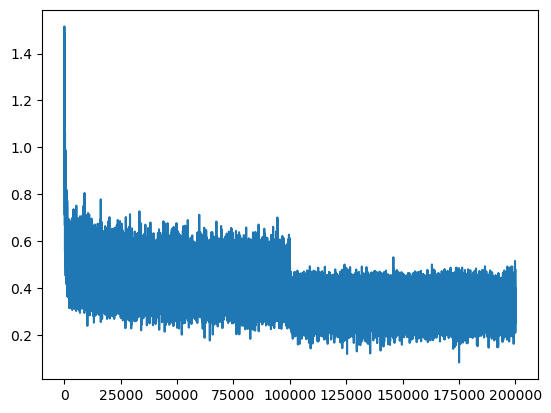

In [14]:
plt.plot(stepi, lossi)

In [15]:
# measure training and validation loss
emb = C[train_X]
h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1)
logits = h @ W2 + b2
print(f"Train loss: {F.cross_entropy(logits, train_Y)}") 

emb = C[valid_X]
h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1)
logits = h @ W2 + b2
print(f"Validation loss: {F.cross_entropy(logits, valid_Y)}") 

Train loss: 2.1856236457824707
Validation loss: 2.2112903594970703


Some notes about training:
1. Instead of going through the entire dataset for each update, we are instead randomly sampling a small subset of the data, known as a "minibatch" and performing an update only based on those examples. The minibatch allows us to approximate the gradient of the loss for the entire dataset. This approach is known as *stochastic gradient descent (SGD)* and converges much faster in practice.
2. We adjust the learning rate based on the number of updates we have performed `lr = 0.1 if i < 100000 else 0.01`. This is called *learning rate decay*, and the rationale behind this is that as we are close to a local optimum, we should take smaller steps to avoid overshooting.
3. We find the actual values (0.1 and 0.01) for the learning rate by first finding some rough upper and lower bounds for a good learning rate through trial and error. Then, we can try multiple learning rates in that range to see when the loss starts to increase again. This is achieved using `lre` above (we use exponentially spaced learning rates, rather than linearly spaced).
4. If after training we see that training loss and validation loss is similar, it is likely that we are underfitting the data and could benefit from increasing the model capacity. On the other hand, if training loss and validation loss start to diverge, it is an indication that the model is starting to overfit.
5. When we look at the loss vs number of updates, we see that the graph has a lot of thickness as it slowly decreases. This is due to the stochastic nature of SGD. The larger the size of the mini-batch, the thinner the graph will be.

Notes about PyTorch:
1. We have the line `emb = C[train_X[ix]]` which maps each training example in the mini-batch to an embedding vector. Note that we can index into `C` which has size `(27, embedding_size)` using `train_X[ix]` which has size `(32, block_size)` to get `(32, block_size, embedding_size)`.
2. We want to concatenate the embedding vectors in each block, to feed into the MLP. There are multiple ways to do this, but using `torch.view` is extremely efficient. This is because under the hood, all tensors have an "underlying storage" which stores all numbers in a one-dimensional vector. `torch.view` just changes the attributes in that underlying storage that determine how those numbers are interpreted, so there is no need to move the tensor in memory.
3. We use `F.cross_entropy` from the PyTorch library which is mathematically equivalent to the softmax we wrote in part 1. However, the library function is much faster and well-behaved for extreme values due to under the hood optimizations.

One way to improve the capacity of the model is to map our tokens to higher dimensional space. When the embedding space is 2-dimensional, we can try plotting the tokens to visualize whether tokens with similar semantics are clustered together and separated from tokens with different semantics.

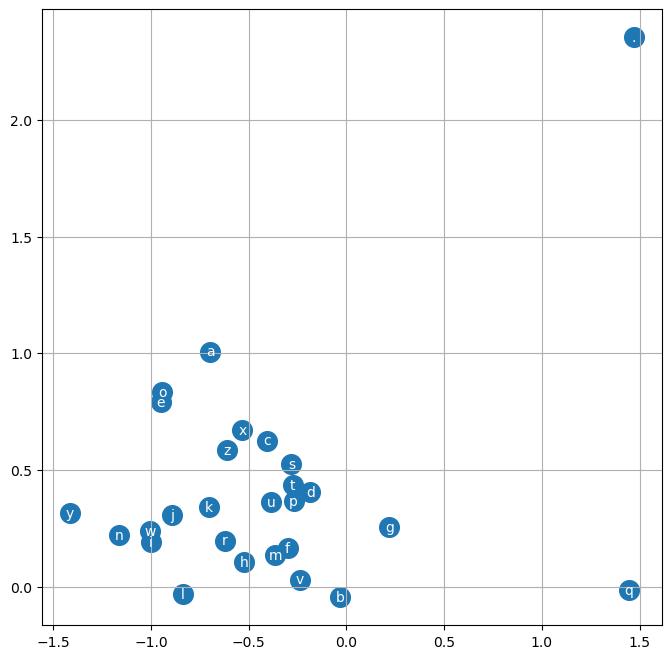

In [16]:
# visualize embedding vectors before scaling up embedding space
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

We can see that the model has learned some semantics about the alphabets (the vowels are clustered in the upper right, and the special character `.` is far away from all the other characters). We could try increasing the embedding space size but it would be harder to visualize.

In [17]:
# goal: beat validation loss of 2.17

In [18]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print("".join(itos[i] for i in out))

cexze.
momlynn.
rorzi.
ahari.
jimitta.
nalla.
kaka.
ar.
samiyah.
javer.
